In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

# 파일 경로 입력
zip_file_name = '/content/drive/MyDrive/multi_class_classification_test2/emotion_images.zip'

# 압축 해제할 경로 입력
extraction_dir = '/content/dataset'

# 압축 해제
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [5]:
from imutils import paths

search_dir = "/content/dataset/emotion_images/data"

search_dir_anger = "/content/dataset/emotion_images/data/anger"
search_dir_embarrassed = "/content/dataset/emotion_images/data/embarrassed"
search_dir_happy = "/content/dataset/emotion_images/data/happy"
search_dir_hurt = "/content/dataset/emotion_images/data/hurt"
search_dir_normal = "/content/dataset/emotion_images/data/normal"
search_dir_sad = "/content/dataset/emotion_images/data/sad"
search_dir_worry = "/content/dataset/emotion_images/data/worry"

image_paths = sorted(
    list(paths.list_images(search_dir))
)
image_paths_anger = sorted(
    list(paths.list_images(search_dir_anger))
)
image_paths_embarrassed = sorted(
    list(paths.list_images(search_dir_embarrassed))
)
image_paths_happy = sorted(
    list(paths.list_images(search_dir_happy))
)
image_paths_hurt = sorted(
    list(paths.list_images(search_dir_hurt))
)
image_paths_normal = sorted(
    list(paths.list_images(search_dir_normal))
)
image_paths_sad = sorted(
    list(paths.list_images(search_dir_sad))
)
image_paths_worry = sorted(
    list(paths.list_images(search_dir_worry))
)

print(">>> total images =", len(image_paths))

print(">>> anger images =", len(image_paths_anger))
print(">>> embarrassed images =", len(image_paths_embarrassed))
print(">>> happy images =", len(image_paths_happy))
print(">>> hurt images =", len(image_paths_hurt))
print(">>> normal images =", len(image_paths_normal))
print(">>> sad images =", len(image_paths_sad))
print(">>> worry images =", len(image_paths_worry))

>>> total images = 3500
>>> anger images = 500
>>> embarrassed images = 500
>>> happy images = 500
>>> hurt images = 500
>>> normal images = 500
>>> sad images = 500
>>> worry images = 500


In [6]:
import os
import cv2
from tqdm import tqdm

image_dim = (180, 180, 3)

images = []
labels = []
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)

    image = cv2.resize(
        image, (image_dim[1], image_dim[0])
    )
    images.append(image)

    label = image_path.split(os.path.sep)[-2]
    labels.append([label])

print(">>> images count =", len(images))

100%|██████████| 3500/3500 [07:04<00:00,  8.25it/s]

>>> images count = 3500


In [7]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

images = np.array(images, dtype='float32') / 255.0
labels = np.array(labels)

mlb = MultiLabelBinarizer()
enc_labels = mlb.fit_transform(labels)

print(f'label shape = {labels}')
print(f'mlb 값 : {mlb}')
print(f'enc_labels : {enc_labels}')
print(">>> classes name =", mlb.classes_)

label shape = [['anger']
 ['anger']
 ['anger']
 ...
 ['worry']
 ['worry']
 ['worry']]
mlb 값 : MultiLabelBinarizer()
enc_labels : [[1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]
>>> classes name = ['anger' 'embarrassed' 'happy' 'hurt' 'normal' 'sad' 'worry']


In [8]:
from sklearn.model_selection import train_test_split

seed = 47

(x_train, x_test, y_train, y_test) = train_test_split(
    images, enc_labels, test_size=0.2, random_state=seed
)
print(">> train test shape = {} {}".format(
    x_train.shape, y_train.shape)
)

>> train test shape = (2800, 180, 180, 3) (2800, 7)


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# ResNet50 모델 불러오기 (ImageNet 사전 훈련된 가중치 사용, 최상위 레이어 포함하지 않음)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# 모델의 출력 레이어 제거 및 새로운 출력 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(mlb.classes_), activation='softmax')(x)  # 분류할 클래스 수에 맞게 설정

# 새로운 모델 정의
model = Model(inputs=base_model.input, outputs=output)


94765736/94765736 [==============================] - 5s 0us/step


In [17]:
# 데이터 증강 설정
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

In [20]:
# 옵티마이저 및 손실 함수 설정
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
learning_rate = 1e-3
optimizer = Adam(
    learning_rate=learning_rate,
    beta_1=0.9, beta_2=0.999, epsilon=1e-07
)
loss = CategoricalCrossentropy(from_logits=False)

In [21]:
# 모델 컴파일
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=['accuracy']
)

In [22]:
# 모델 요약 출력
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 186, 186, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 90, 90, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 90, 90, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [23]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=128),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // 128,
    epochs=200, verbose=1
)

Epoch 1/200
21/21 [==============================] - 68s 1s/step - loss: 1.7919 - accuracy: 0.3391 - val_loss: 373.0088 - val_accuracy: 0.1343
Epoch 2/200
21/21 [==============================] - 19s 888ms/step - loss: 1.1693 - accuracy: 0.5535 - val_loss: 54.6748 - val_accuracy: 0.1314
Epoch 3/200
21/21 [==============================] - 19s 893ms/step - loss: 0.9418 - accuracy: 0.6344 - val_loss: 36.8336 - val_accuracy: 0.1314
Epoch 4/200
21/21 [==============================] - 19s 875ms/step - loss: 0.7886 - accuracy: 0.6976 - val_loss: 25.6877 - val_accuracy: 0.1314
Epoch 5/200
21/21 [==============================] - 19s 869ms/step - loss: 0.7157 - accuracy: 0.7275 - val_loss: 2.1593 - val_accuracy: 0.1514
Epoch 6/200
21/21 [==============================] - 19s 879ms/step - loss: 0.6643 - accuracy: 0.7369 - val_loss: 2.9913 - val_accuracy: 0.1529
Epoch 7/200
21/21 [==============================] - 19s 885ms/step - loss: 0.6264 - accuracy: 0.7601 - val_loss: 3.3290 - val_accurac

In [9]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense

# class Classifier:
# 	def build(width, height, depth, classes):
# 		model = Sequential()
# 		input_shape = (height, width, depth)

# 		model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(MaxPooling2D(pool_size=(3, 3)))
# 		model.add(Dropout(0.25))

# 		model.add(Conv2D(64, (3, 3), padding='same'))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(Conv2D(64, (3, 3), padding='same'))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(MaxPooling2D(pool_size=(2, 2)))
# 		model.add(Dropout(0.25))

# 		model.add(Conv2D(128, (3, 3), padding='same'))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(Conv2D(128, (3, 3), padding='same'))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(MaxPooling2D(pool_size=(2, 2)))
# 		model.add(Dropout(0.25))

# 		model.add(Conv2D(256, (3, 3), padding='same'))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(Conv2D(256, (3, 3), padding='same'))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization(axis=-1))
# 		model.add(MaxPooling2D(pool_size=(2, 2)))
# 		model.add(Dropout(0.25))

# 		model.add(Flatten())
# 		model.add(Dense(2048))
# 		model.add(Activation('relu'))
# 		model.add(BatchNormalization())
# 		model.add(Dropout(0.5))

# 		model.add(Dense(classes))
# 		model.add(Activation('softmax'))
# 		return model

# model = Classifier.build(
#     width=image_dim[1], height=image_dim[0], depth=image_dim[2],
#     classes=len(mlb.classes_)
# )

In [10]:
# from tensorflow.keras.losses import CategoricalCrossentropy
# from tensorflow.keras.optimizers import Adam

# batch_size = 256
# epoch = 200
# learning_rate = 1e-3


# optimizer = Adam(
#     learning_rate=learning_rate,
#     beta_1=0.9, beta_2=0.999, epsilon=1e-07
# )

# loss = CategoricalCrossentropy(from_logits=False)

# model.compile(
#     loss=loss,
#     optimizer=optimizer,
# 	metrics=['accuracy']
# )

In [11]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# aug = ImageDataGenerator(
#     rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
# )

In [12]:
# history = model.fit_generator(
# 	aug.flow(
#         x_train, y_train, batch_size=batch_size
#     ),
# 	validation_data=(x_test, y_test),
# 	steps_per_epoch=len(x_train) // batch_size,
# 	epochs=epoch, verbose=1
# )

<ipython-input-12-38b69b003586>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/200
10/10 [==============================] - 56s 3s/step - loss: 3.4694 - accuracy: 0.1576 - val_loss: 1.9961 - val_accuracy: 0.1314
Epoch 2/200
10/10 [==============================] - 17s 2s/step - loss: 2.6536 - accuracy: 0.1619 - val_loss: 2.2398 - val_accuracy: 0.1343
Epoch 3/200
10/10 [==============================] - 17s 2s/step - loss: 2.2360 - accuracy: 0.1954 - val_loss: 2.5278 - val_accuracy: 0.1343
Epoch 4/200
10/10 [==============================] - 17s 2s/step - loss: 2.2031 - accuracy: 0.2017 - val_loss: 2.8054 - val_accuracy: 0.1343
Epoch 5/200
10/10 [==============================] - 17s 2s/step - loss: 2.1553 - accuracy: 0.1875 - val_loss: 3.6667 - val_accuracy: 0.1343
Epoch 6/200
10/10 [==============================] - 17s 2s/step - loss: 2.1420 - accuracy: 0.2056 - val_loss: 3.3865 - val_accuracy: 0.1343
Epoch 7/200
10/10 [==============================] - 17s 2s/step - loss: 2.0959 - accuracy: 0.1977 - val_loss: 4.0883 - val_accuracy: 0.1343
Epoch 8/200
1

KeyboardInterrupt: 

In [24]:
test_image_paths = sorted(
    list(
        paths.list_images("/content/dataset/emotion_images/images")
    )
)
print(">>> test image path =", test_image_paths)

>>> test image path = ['/content/dataset/emotion_images/images/anger (1).jpg', '/content/dataset/emotion_images/images/anger (2).jpg', '/content/dataset/emotion_images/images/anger (3).jpg', '/content/dataset/emotion_images/images/embarrassed (1).jpg', '/content/dataset/emotion_images/images/embarrassed (2).jpg', '/content/dataset/emotion_images/images/embarrassed (3).jpg', '/content/dataset/emotion_images/images/happy (1).jpg', '/content/dataset/emotion_images/images/happy (2).jpg', '/content/dataset/emotion_images/images/happy (3).jpg', '/content/dataset/emotion_images/images/hurt (1).jpg', '/content/dataset/emotion_images/images/hurt (2).jpg', '/content/dataset/emotion_images/images/hurt (3).jpg', '/content/dataset/emotion_images/images/normal (1).jpg', '/content/dataset/emotion_images/images/normal (2).jpg', '/content/dataset/emotion_images/images/normal (3).jpg', '/content/dataset/emotion_images/images/sad (1).jpg', '/content/dataset/emotion_images/images/sad (2).jpg', '/content/d

In [ ]:
# from tensorflow.keras.models import load_model

# # 모델 로드
# model = load_model('/content/drive/MyDrive/multi_class_classification_test2/model.keras')

>>> class index = ['anger' 'embarrassed' 'happy' 'hurt' 'normal' 'sad' 'worry']


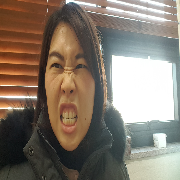

1/1 [==============================] - 2s 2s/step
[1. 0. 0. 0. 0. 0. 0.]
>>> predict class = anger
>>> actual class = anger (1).jpg


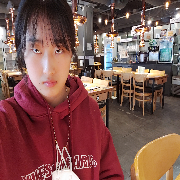

1/1 [==============================] - 0s 25ms/step
[0.989 0.001 0.001 0.    0.008 0.    0.001]
>>> predict class = anger
>>> actual class = anger (2).jpg


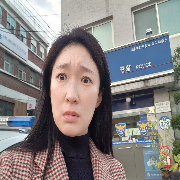

1/1 [==============================] - 0s 26ms/step
[0.    0.084 0.    0.915 0.    0.    0.   ]
>>> predict class = hurt
>>> actual class = anger (3).jpg


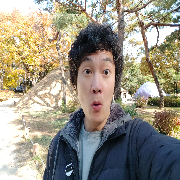

1/1 [==============================] - 0s 24ms/step
[0. 1. 0. 0. 0. 0. 0.]
>>> predict class = embarrassed
>>> actual class = embarrassed (1).jpg


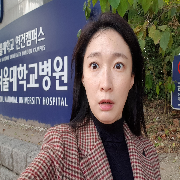

1/1 [==============================] - 0s 25ms/step
[0. 1. 0. 0. 0. 0. 0.]
>>> predict class = embarrassed
>>> actual class = embarrassed (2).jpg


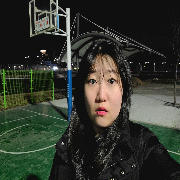

1/1 [==============================] - 0s 25ms/step
[0.    0.001 0.    0.001 0.027 0.    0.971]
>>> predict class = worry
>>> actual class = embarrassed (3).jpg


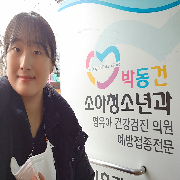

1/1 [==============================] - 0s 26ms/step
[0. 0. 1. 0. 0. 0. 0.]
>>> predict class = happy
>>> actual class = happy (1).jpg


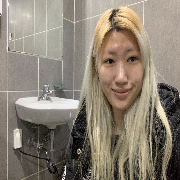

1/1 [==============================] - 0s 28ms/step
[0. 0. 1. 0. 0. 0. 0.]
>>> predict class = happy
>>> actual class = happy (2).jpg


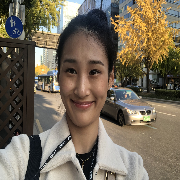

1/1 [==============================] - 0s 26ms/step
[0.287 0.    0.711 0.    0.    0.    0.001]
>>> predict class = happy
>>> actual class = happy (3).jpg


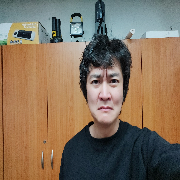

1/1 [==============================] - 0s 26ms/step
[0.    0.    0.    0.002 0.    0.998 0.   ]
>>> predict class = sad
>>> actual class = hurt (1).jpg


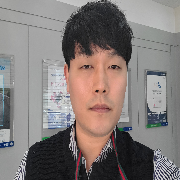

1/1 [==============================] - 0s 25ms/step
[0.001 0.    0.    0.978 0.    0.018 0.002]
>>> predict class = hurt
>>> actual class = hurt (2).jpg


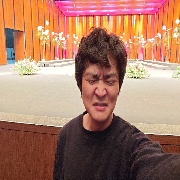

1/1 [==============================] - 0s 25ms/step
[0.677 0.    0.001 0.012 0.    0.242 0.069]
>>> predict class = anger
>>> actual class = hurt (3).jpg


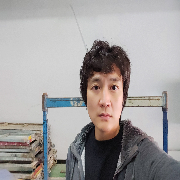

1/1 [==============================] - 0s 26ms/step
[0.002 0.    0.001 0.    0.998 0.    0.   ]
>>> predict class = normal
>>> actual class = normal (1).jpg


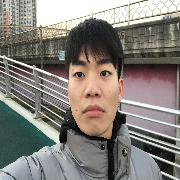

1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 0. 1. 0. 0.]
>>> predict class = normal
>>> actual class = normal (2).jpg


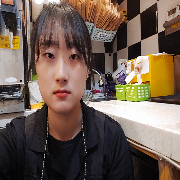

1/1 [==============================] - 0s 24ms/step
[0. 0. 0. 0. 1. 0. 0.]
>>> predict class = normal
>>> actual class = normal (3).jpg


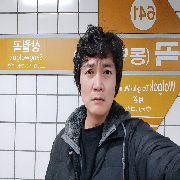

1/1 [==============================] - 0s 24ms/step
[0.007 0.014 0.002 0.066 0.019 0.824 0.067]
>>> predict class = sad
>>> actual class = sad (1).jpg


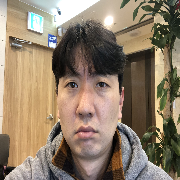

1/1 [==============================] - 0s 25ms/step
[0.    0.    0.    0.075 0.001 0.916 0.007]
>>> predict class = sad
>>> actual class = sad (2).jpg


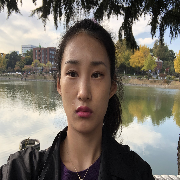

1/1 [==============================] - 0s 25ms/step
[0.002 0.    0.    0.    0.998 0.    0.   ]
>>> predict class = normal
>>> actual class = sad (3).jpg


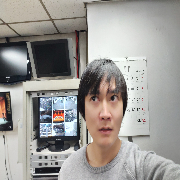

1/1 [==============================] - 0s 25ms/step
[0.    0.95  0.    0.    0.001 0.    0.049]
>>> predict class = embarrassed
>>> actual class = worry (1).jpg


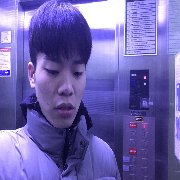

1/1 [==============================] - 0s 25ms/step
[0. 0. 0. 1. 0. 0. 0.]
>>> predict class = hurt
>>> actual class = worry (2).jpg


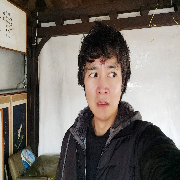

1/1 [==============================] - 0s 25ms/step
[0.003 0.    0.    0.    0.    0.    0.997]
>>> predict class = worry
>>> actual class = worry (3).jpg


In [25]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

print(">>> class index =", mlb.classes_)

for image_path in test_image_paths:
    test_image = cv2.imread(image_path)

    if test_image is None:
        print(f"Error loading image {image_path}")
        continue

    # 이미지 리사이징
    test_image = cv2.resize(test_image, (180, 180))  # 모델이 예상하는 크기로 조정

    cv2_imshow(test_image)

    # 이미지 전처리
    test_image = test_image.astype("float32") / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    try:
        # 모델 예측
        proba = model.predict(test_image)[0]
        print(np.round(proba, 3))
        idx = np.argmax(proba)
        print(">>> predict class =", mlb.classes_[idx])
        print(f">>> actual class = {image_path.split(os.path.sep)[-1]}")
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")

In [26]:
# 모델 전체 저장
model.save('/content/drive/MyDrive/multi_class_classification_test2/emotion_model.keras')


In [27]:
# 모델 전체 저장
model.save('/content/drive/MyDrive/multi_class_classification_test2/emotion_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
# 가중치만 저장
model.save_weights('/content/drive/MyDrive/multi_class_classification_test2/emotion_weights.keras')

In [ ]:
# # 모델 구조를 정의한 후
# model = Classifier.build(width=180, height=180, depth=3, classes=len(mlb.classes_))

# # 저장된 가중치 로드
# model.load_weights('path_to_your_model/weights.keras')